In [37]:
import requests
from bs4 import BeautifulSoup
import time
import random
import logging
import pandas as pd

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class AmazonScraper:
    def __init__(self):
        self.session = requests.Session()
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept-Language': 'en-US,en;q=0.9',
        }

    def throttle_request(self):
        time.sleep(random.uniform(2, 5))

    def scrape_product(self, url):
        retry_count = 0
        max_retries = 3
        while retry_count < max_retries:
            try:
                self.throttle_request()
                response = self.session.get(url, headers=self.headers, timeout=2)
                if response.status_code == 200:
                    return self.parse_product_page(response.content)
                else:
                    logging.error(f"Unexpected status code: {response.status_code}")
                    break
            except requests.RequestException as e:
                logging.error(f"Request failed: {e}")
            retry_count += 1
            time.sleep(random.uniform(5, 10))  # Longer wait on retry
        return None

    def parse_product_page(self, content):
        soup = BeautifulSoup(content, 'html.parser')
        data = {}
        
        # Extract product title
        title_elem = soup.find('span', {'id': 'productTitle'})
        data['title'] = title_elem.text.strip() if title_elem else None

        # Extract price
        price_elem = soup.find('span', {'class': 'a-price-whole'})
        if price_elem:
            data['price'] = price_elem.text.strip()
        else:
            price_elem = soup.find('span', {'class': 'a-offscreen'})
            data['price'] = price_elem.text.strip() if price_elem else None

        # Extract category
        category_elem = soup.find('a', {'class': 'a-link-normal a-color-tertiary'})
        data['category'] = category_elem.text.strip() if category_elem else None

        # Extract rating
        rating_elem = soup.find('span', {'class': 'a-icon-alt'})
        data['rating'] = rating_elem.text.split()[0] if rating_elem else None

        # Extract number of reviews
        review_count_elem = soup.find('span', {'id': 'acrCustomerReviewText'})
        data['review_count'] = review_count_elem.text.split()[0] if review_count_elem else None

        # Extract product features
        feature_bullets = soup.find('div', {'id': 'feature-bullets'})
        if feature_bullets:
            data['features'] = [li.text.strip() for li in feature_bullets.find_all('li')]

        # Extract "Frequently bought together" products
        frequently_bought_together = soup.find('div', {'id': 'sims-fbt-container'})
        if frequently_bought_together:
            data['frequently_bought_together'] = [item.text.strip() for item in frequently_bought_together.find_all('span', {'class': 'a-truncate-cut'})]

        # Extract "Customers also viewed" products
        customers_also_viewed = soup.find('div', {'id': 'similarity-drawer'})
        if customers_also_viewed:
            data['customers_also_viewed'] = [item.text.strip() for item in customers_also_viewed.find_all('span', {'class': 'a-truncate-cut'})]

        # Extract product dimensions
        product_details = soup.find('div', {'id': 'productDetails_detailBullets_sections1'})
        if product_details:
            for row in product_details.find_all('tr'):
                if 'Product Dimensions' in row.text:
                    data['dimensions'] = row.find('td').text.strip()
                    break

        # Extract Best Sellers Rank
        rank_elem = soup.find('span', {'class': 'zg-badge-text'})
        if rank_elem:
            data['best_sellers_rank'] = rank_elem.text.split('#')[1].strip()
        else:
            rank_section = soup.find('th', string='Best Sellers Rank')
            if rank_section:
                rank_text = rank_section.find_next('td').text.strip()
                data['best_sellers_rank'] = rank_text

        return data

    def scrape_category(self, category_url, max_products=10):
        all_products = []
        page = 1
        while len(all_products) < max_products:
            url = f"{category_url}&page={page}"
            self.throttle_request()
            response = self.session.get(url, headers=self.headers, timeout=15)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                product_cards = soup.select('div[data-component-type="s-search-result"]')
                
                for card in product_cards:
                    if len(all_products) >= max_products:
                        break
                    
                    product_data = {}
                    
                    # Extract title
                    title_elem = card.select_one('h2 a.a-link-normal')
                    product_data['title'] = title_elem.text.strip() if title_elem else None
                    
                    # Extract price
                    price_elem = card.select_one('span.a-price-whole')
                    product_data['price'] = price_elem.text.strip() if price_elem else None
                    
                    # Extract rating
                    rating_elem = card.select_one('span.a-icon-alt')
                    product_data['rating'] = rating_elem.text.split()[0] if rating_elem else None
                    
                    # Extract review count
                    review_count_elem = card.select_one('span.a-size-base.s-underline-text')
                    product_data['review_count'] = review_count_elem.text.strip() if review_count_elem else None
                    
                    all_products.append(product_data)
                    logging.info(f"Scraped product {len(all_products)}: {product_data['title']}")
                
                # Check if there's a next page
                next_page = soup.select_one('a.s-pagination-next')
                if not next_page:
                    break
                
                page += 1
            else:
                logging.error(f"Failed to fetch category page {page}: {response.status_code}")
                break

        logging.info(f"Scraped {len(all_products)} products from the category.")
        return all_products

if __name__ == "__main__":
    scraper = AmazonScraper()
    analyzer = NicheAnalyzer()
    
    category_url = "https://www.amazon.co.uk/b/?node=3229437031&ref_=Oct_d_odnav_d_11716391_2&pd_rd_w=iprS0&content-id=amzn1.sym.7414f21e-2c95-4394-9a75-8c1b3641bcea&pf_rd_p=7414f21e-2c95-4394-9a75-8c1b3641bcea&pf_rd_r=MXEDEFJMBQDCRWPWJC99&pd_rd_wg=FxpQ9&pd_rd_r=16d86c9c-9283-41aa-ac41-d0f8c5dfa41e"
    
    products = scraper.scrape_category(category_url, max_products=10)
    
    analysis = analyzer.analyze_niche_opportunities(products)
    

2024-09-29 17:30:06,171 - INFO - Scraped product 1: Platinum Ice Pack of 12 Kitchen Towel's–100% Cotton, Large 20” x 30” (50cm x 76cm) Dish Towels - Ultra Absorbent, Durable, Washable Green
2024-09-29 17:30:06,172 - INFO - Scraped product 2: Tea Towels 12 Pack Extra Large 50 X 80 cm Kitchen Towels Set, Lint Free Kitchen Cloth with 6 Assorted Colors, Soft Absorbent Dish Towels and Bar Towels, 100% Terry Towelling Cotton Dish Cloths
2024-09-29 17:30:06,172 - INFO - Scraped product 3: Premium Cotton Kitchen Towel Set - 40cm x 64cm Tea Towels, Dish Cloth, Highly Absorbent | Ideal for Drying, Cleaning (Black & Yarn Black, Pack of 8)
2024-09-29 17:30:06,173 - INFO - Scraped product 4: Tea Towels – 100% Cotton Kitchen Tea towels- Pack of 5 and Absorbent Tea Towels set, 70 x 50 cm Towels (Grey)
2024-09-29 17:30:06,173 - INFO - Scraped product 5: Stripe Designed Tea Towels for Kitchen - 100% Cotton | Super Absorbent & Quick Drying Hotel Quality Kitchen Towels Set | 60 x 40 cm - Machine Washable

In [43]:
import requests
from bs4 import BeautifulSoup
import time
import random
import logging
import pandas as pd
import csv
from urllib.parse import quote

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class AmazonScraper:
    def __init__(self):
        self.session = requests.Session()
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept-Language': 'en-US,en;q=0.9',
        }

    def throttle_request(self):
        time.sleep(random.uniform(5, 10))  # Increased delay between requests

    def scrape_category(self, category, max_products=100):
        all_products = []
        page = 1
        encoded_category = quote(category)
        base_url = f"https://www.amazon.co.uk/s?k={encoded_category}&ref=nb_sb_noss_1"
        
        while len(all_products) < max_products:
            url = f"{base_url}&page={page}"
            self.throttle_request()
            response = self.session.get(url, headers=self.headers, timeout=15)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                product_cards = soup.select('div[data-component-type="s-search-result"]')
                
                for card in product_cards:
                    if len(all_products) >= max_products:
                        break
                    
                    product_data = {'category': category}
                    
                    # Extract title
                    title_elem = card.select_one('h2 a.a-link-normal')
                    product_data['title'] = title_elem.text.strip() if title_elem else None
                    
                    # Extract price
                    price_elem = card.select_one('span.a-price-whole')
                    product_data['price'] = price_elem.text.strip() if price_elem else None
                    
                    # Extract rating
                    rating_elem = card.select_one('span.a-icon-alt')
                    product_data['rating'] = rating_elem.text.split()[0] if rating_elem else None
                    
                    # Extract review count
                    review_count_elem = card.select_one('span.a-size-base.s-underline-text')
                    product_data['review_count'] = review_count_elem.text.strip() if review_count_elem else None
                    
                    all_products.append(product_data)
                    logging.info(f"Scraped product {len(all_products)} for {category}: {product_data['title']}")
                
                # Check if there's a next page
                next_page = soup.select_one('a.s-pagination-next')
                if not next_page:
                    break
                
                page += 1
            else:
                logging.error(f"Failed to fetch category page {page} for {category}: {response.status_code}")
                break

        logging.info(f"Scraped {len(all_products)} products from the category {category}.")
        return all_products

def scrape_all_categories(categories):
    scraper = AmazonScraper()
    all_data = []

    for category in categories:
        if isinstance(category, list):
            for subcategory in category:
                products = scraper.scrape_category(f"{category[0]} {subcategory}", max_products=100)
                all_data.extend(products)
        else:
            products = scraper.scrape_category(category, max_products=100)
            all_data.extend(products)
        
        time.sleep(random.uniform(10, 20))

    return all_data

def save_to_csv(data, filename):
    keys = data[0].keys()
    with open(filename, 'w', newline='', encoding='utf-8') as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(data)

if __name__ == "__main__":
    categories = [
        "All Departments", "Apps & Games", 
        "Baby", "Beauty", "Books", "Car & Motorbike", "Computers & Accessories", "Deals", 
        "DIY & Tools", "DVD & Blu-ray", "Electronics & Photo", "Fashion",
        ["Fashion", "Women", "Men", "Girls", "Boys", "Baby"],
        "Garden & Outdoors", "Gift Cards", "Grocery", "Handmade",
        "Health & Personal Care", "Home & Business Services", "Home & Kitchen",
        "Industrial & Scientific", "Large Appliances", "Lighting",
        "Luggage and travel gear", "Luxury Stores",
        "Musical Instruments & DJ Equipment", "PC & Video Games", "Pet Supplies",
        "Premium Beauty", "Sports & Outdoors",
        "Stationery & Office Supplies", "Toys & Games"
    ]

    all_products = scrape_all_categories(categories)
    save_to_csv(all_products, 'amazon_products.csv')
    logging.info("Scraping completed. Data saved to amazon_products.csv")

2024-09-29 18:08:16,755 - INFO - Scraped product 1 for All Departments: Men's Casual Summer Combat Cotton Twill Cargo Shorts
2024-09-29 18:08:16,756 - INFO - Scraped product 2 for All Departments: Lyric Inspired Gift Poets Department Merch Concert Tour Merch Singer New Album Gift Singer Concert Gift Music Lover Gift
2024-09-29 18:08:16,757 - INFO - Scraped product 3 for All Departments: MOQIYXL Inspirational Gifts for Men Women, Sometimes You Forget You're Awesome, Metal Engraved Motivational Quotes Wallet Card
2024-09-29 18:08:16,757 - INFO - Scraped product 4 for All Departments: Artcome Premium Heavy-Duty Pecan and Walnut Nutcracker with Ergonomic Handle
2024-09-29 18:08:16,757 - INFO - Scraped product 5 for All Departments: MRI Tech Christmas Squad Radiologic Technologist Technician T-Shirt
2024-09-29 18:08:16,758 - INFO - Scraped product 6 for All Departments: Children's Catholic Book for Girls: God Made You: Watercolor Illustrated Bible Verses Catholic Books for Kids in All Depar

In [45]:
import pandas as pd

df = pd.read_csv('amazon_products.csv')

print(df.head())
print(df.info())


          category                                              title price  \
0  All Departments  Men's Casual Summer Combat Cotton Twill Cargo ...   24.   
1  All Departments  Lyric Inspired Gift Poets Department Merch Con...   12.   
2  All Departments  MOQIYXL Inspirational Gifts for Men Women, Som...   11.   
3  All Departments  Artcome Premium Heavy-Duty Pecan and Walnut Nu...    3.   
4  All Departments  MRI Tech Christmas Squad Radiologic Technologi...   17.   

   rating review_count  
0     3.9          740  
1     NaN          NaN  
2     4.7           32  
3     3.4           20  
4     NaN          NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3418 entries, 0 to 3417
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   category      3418 non-null   object 
 1   title         3418 non-null   object 
 2   price         3356 non-null   object 
 3   rating        3173 non-null   float64
 4   review

In [47]:
df_clean = df.dropna(subset=['price', 'rating', 'review_count'])

df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')
df_clean['rating'] = pd.to_numeric(df_clean['rating'], errors='coerce')
df_clean['review_count'] = pd.to_numeric(df_clean['review_count'], errors='coerce')

df_clean = df_clean.dropna(subset=['price', 'rating', 'review_count'])


/var/folders/3v/824h61h90xl37fhnnb4sr1hc0000gn/T/ipykernel_66490/2669207289.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')
/var/folders/3v/824h61h90xl37fhnnb4sr1hc0000gn/T/ipykernel_66490/2669207289.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['rating'] = pd.to_numeric(df_clean['rating'], errors='coerce')
/var/folders/3v/824h61h90xl37fhnnb4sr1hc0000gn/T/ipykernel_66490/2669207289.py:6: SettingWithCopyWarning: 
A value

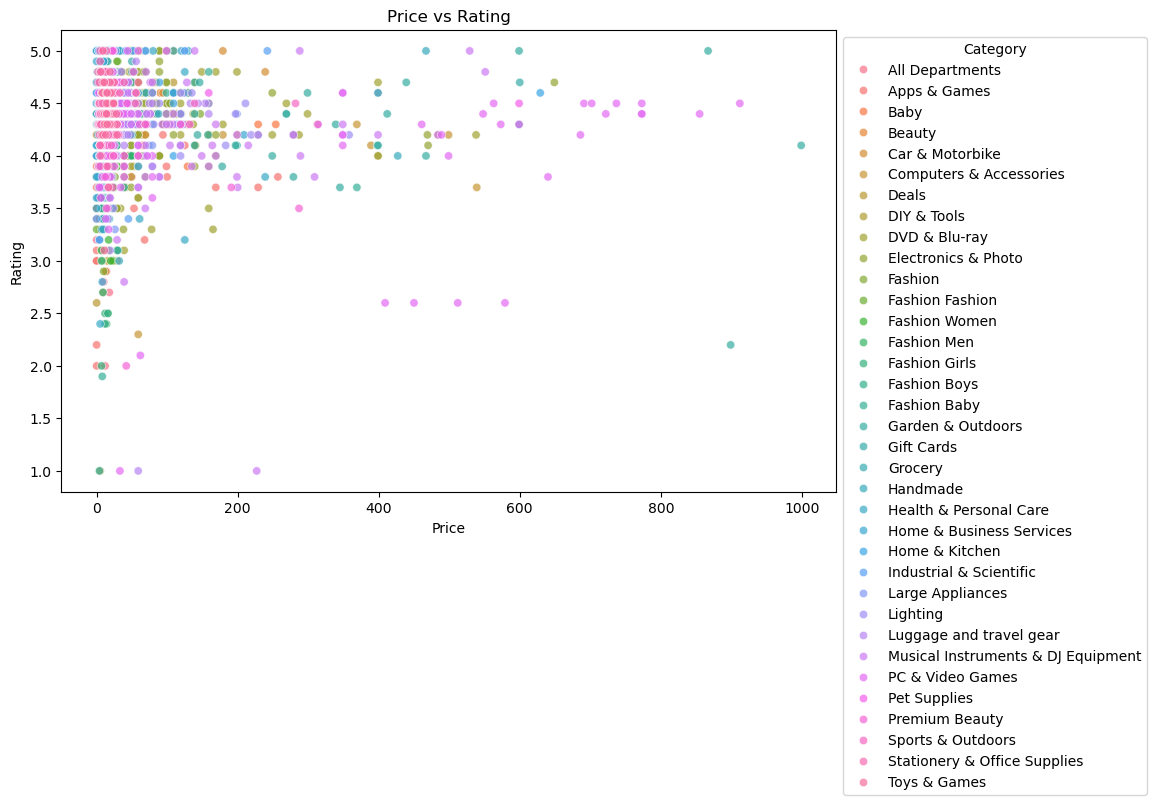

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='price', y='rating', hue='category', alpha=0.7)
plt.title('Price vs Rating')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.legend(title='Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


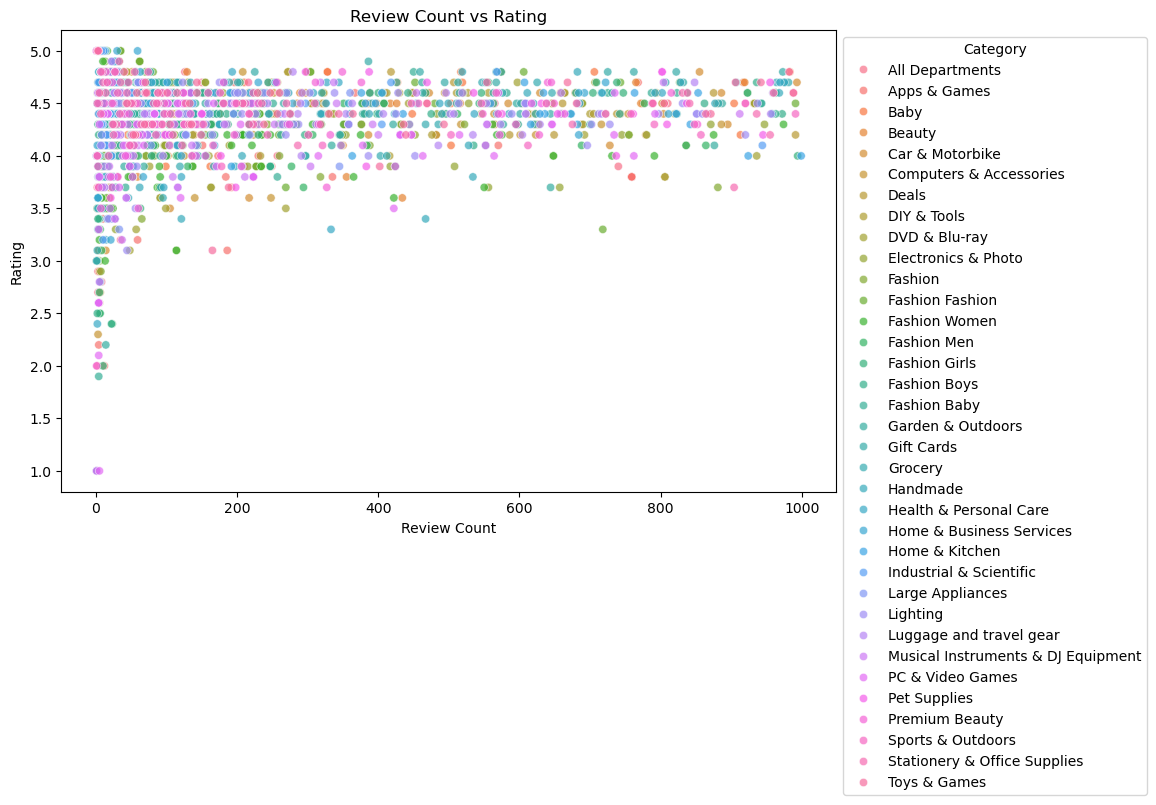

In [51]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='review_count', y='rating', hue='category', alpha=0.7)
plt.title('Review Count vs Rating')
plt.xlabel('Review Count')
plt.ylabel('Rating')
plt.legend(title='Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

# Prepare data for modeling
le = LabelEncoder()
df_clean['category_encoded'] = le.fit_transform(df_clean['category'])

# Define features and target
X = df_clean[['rating', 'review_count', 'category_encoded']]
y = df_clean['price']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 11608.733087549843
